In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
!unzip "/content/gdrive/MyDrive/gdriveupmebot/archive.zip" -d "/tmp/data"

In [ ]:
!pip install split_folders

In [40]:
import os
import numpy as np
import pandas as pd
from matplotlib.image import imread
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import splitfolders

# Preprocessing

In [57]:
main_dir="/tmp/data/Brain Tumor Data Set/Brain Tumor Data Set/"

In [5]:
print("==========================Number of pictures")

for sub_dir in os.listdir(main_dir):
  print(sub_dir+": "+str(len(os.listdir(main_dir+sub_dir))))  

==========================Number of pictures
Brain Tumor: 2513
Healthy: 2087


In [6]:
sample=Image.open(main_dir+"Brain Tumor/Cancer (55).jpg")

(512, 512)
RGB


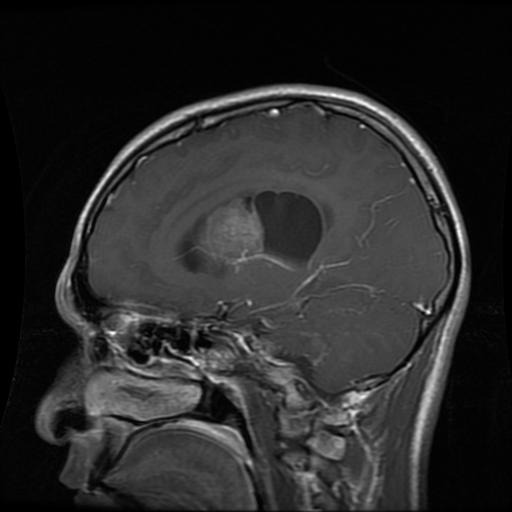

In [7]:
print(f'{sample.size}')
print(f'{sample.mode}')
sample

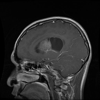

In [8]:
sample.resize((100,100))

In [9]:
subDir=["Brain Tumor", "Healthy"]

Storing data

In [10]:
data=[]

for i in range(2):
  for pic in os.listdir(main_dir+"/"+subDir[i]):
    data.append([Image.open(main_dir+"/"+subDir[i]+"/"+pic),i])

In [11]:
data[0]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=283x338 at 0x7F27254697D0>,
 0]

In [12]:
len(data)

4600

Manual Under Sampeling

In [13]:
balanced_data=data[426:]

In [14]:
len(balanced_data)

4174

In [15]:
width=[]
height=[]
channels=[]

for i in balanced_data:
  widtht, heightt= i[0].size

  width.append(widtht)
  height.append(heightt)
  channels.append(i[0].mode)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


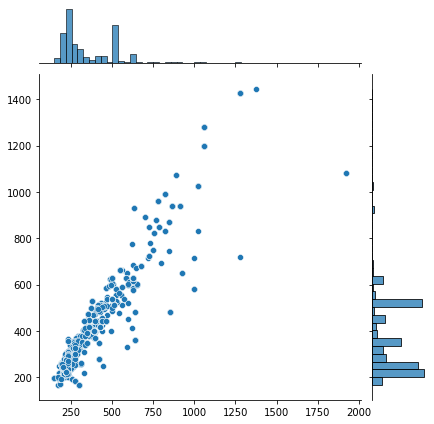

In [16]:
sns.jointplot(width, height)

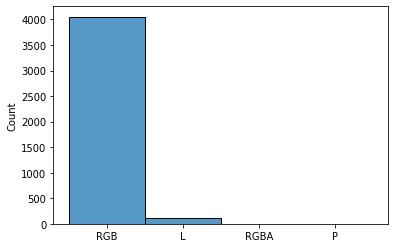

In [17]:
sns.histplot(channels)

In [18]:
width=0
height=0

for i in range(len(balanced_data)-1,-1,-1):
  width, height= balanced_data[i][0].size
  if ((width>1100) | (height>1100)):
    balanced_data.pop(i)

Resizing and converting to black and white

In [19]:
for i in range(len(balanced_data)):
  balanced_data[i][0]=np.asarray(balanced_data[i][0].resize((100,100)).convert("L")).astype("float32")

In [20]:
random.shuffle(balanced_data)

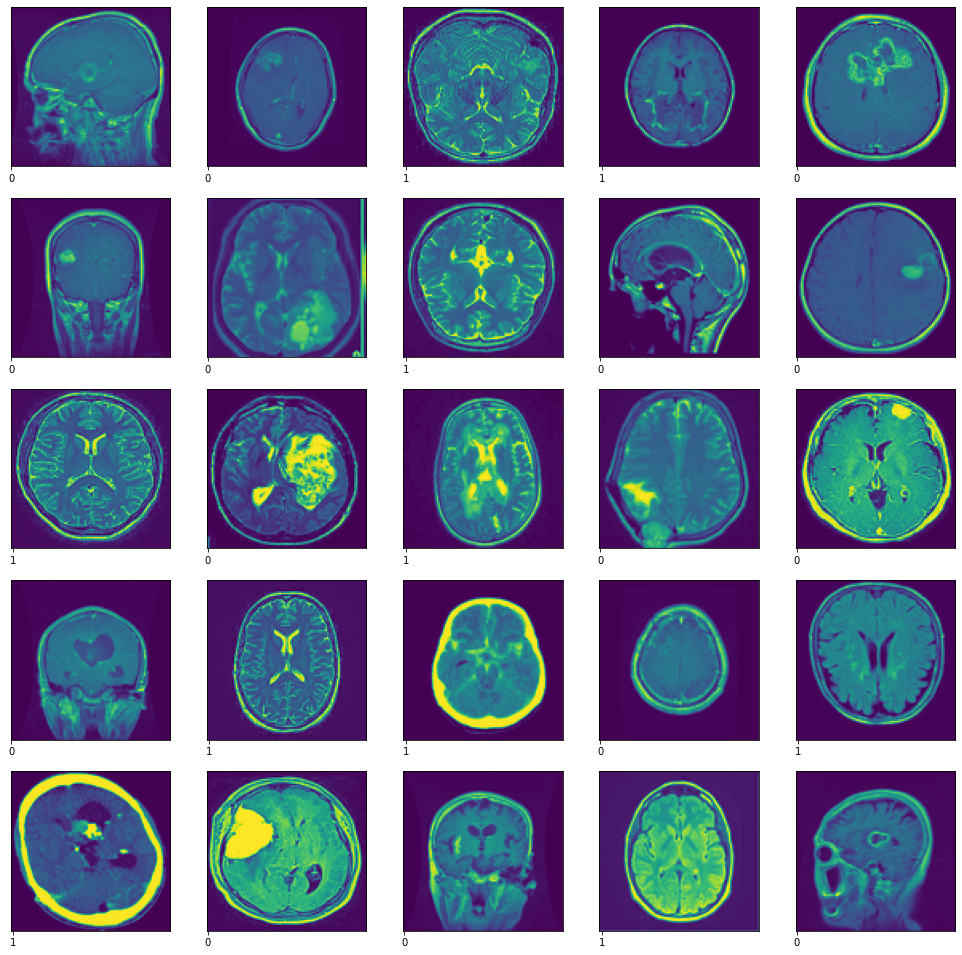

In [21]:
fig, ax = plt.subplots(5, 5, figsize=(17, 17))
n = 0
for i in range(5):
    for j in range(5):
        ax[i, j].set_xticks([balanced_data[n][1]])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(balanced_data[n][0])
        n += 1

# Model

In [37]:
def Eval(prediction, ytest):
  print("class_rep:")
  print(classification_report(prediction,ytest))
  print("conf_matrix:")
  print(confusion_matrix(prediction,ytest))

In [22]:
xtrain, xtest, ytrain, ytest= train_test_split([np.divide(x[0],255) for x in balanced_data], [y[1] for y in balanced_data])

In [23]:
xtrain=np.array(xtrain).reshape(-1,100,100,1)

In [24]:
ytrain=to_categorical(ytrain)

In [25]:
es=EarlyStopping(patience=4)

In [26]:
model=Sequential()

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(MaxPool2D(3,3))

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(MaxPool2D(3,3))

model.add(Flatten())

model.add(Dense(32, activation="relu"))

model.add(Dense(2, activation="softmax"))


model.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer="rmsprop")

model.fit(xtrain, ytrain, validation_split=.2, epochs=1500,  callbacks=[es])

Epoch 1/1500
78/78 [==============================] - 15s 34ms/step - loss: 0.6081 - accuracy: 0.6581 - val_loss: 0.4402 - val_accuracy: 0.8215
Epoch 2/1500
78/78 [==============================] - 2s 20ms/step - loss: 0.4305 - accuracy: 0.8085 - val_loss: 0.4199 - val_accuracy: 0.8183
Epoch 3/1500
78/78 [==============================] - 1s 18ms/step - loss: 0.3429 - accuracy: 0.8500 - val_loss: 0.3194 - val_accuracy: 0.8746
Epoch 4/1500
78/78 [==============================] - 2s 22ms/step - loss: 0.2666 - accuracy: 0.8950 - val_loss: 0.2782 - val_accuracy: 0.8842
Epoch 5/1500
78/78 [==============================] - 2s 19ms/step - loss: 0.2152 - accuracy: 0.9175 - val_loss: 0.2918 - val_accuracy: 0.8955
Epoch 6/1500
78/78 [==============================] - 2s 21ms/step - loss: 0.1788 - accuracy: 0.9332 - val_loss: 0.2348 - val_accuracy: 0.9132
Epoch 7/1500
78/78 [==============================] - 2s 23ms/step - loss: 0.1282 - accuracy: 0.9574 - val_loss: 0.2774 - val_accuracy: 0.887

# Evaluation

In [27]:
hist=pd.DataFrame(model.history.history)

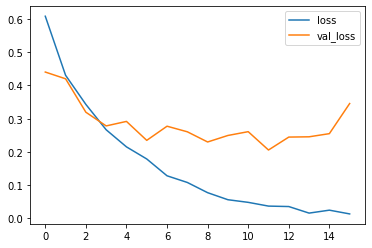

In [28]:
hist[["loss","val_loss"]].plot()

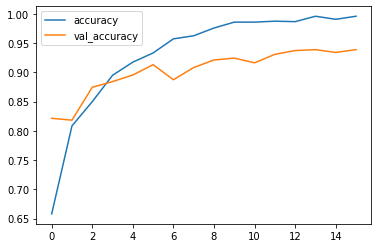

In [29]:
hist[["accuracy","val_accuracy"]].plot()

In [30]:
xtest=np.array(xtest).reshape(-1,100,100,1)

In [31]:
prediction=np.argmax(model.predict(xtest), axis=-1)

In [38]:
Eval(prediction, ytest)

class_rep:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       506
           1       0.98      0.93      0.95       530

    accuracy                           0.95      1036
   macro avg       0.95      0.95      0.95      1036
weighted avg       0.96      0.95      0.95      1036

conf_matrix:
[[497   9]
 [ 39 491]]


#Model 2

In [64]:
2513-2087

426

In [65]:
counter=0
for i in os.listdir(main_dir+"/Brain Tumor"):
  if counter==426:
    break
  
  os.remove(main_dir+"/Brain Tumor/"+i)
  counter += 1

In [66]:
for sub_dir in os.listdir(main_dir):
  print(sub_dir+": "+str(len(os.listdir(main_dir+sub_dir))))  

Brain Tumor: 2087
Healthy: 2087


In [73]:
splitfolders.ratio(main_dir, "/tmp/processed", (.75,.125,.125))

Copying files: 4174 files [00:01, 2332.42 files/s]


In [74]:
train_path="/tmp/processed/train"
test_path="/tmp/processed/test"
val_path="/tmp/processed/val"

In [75]:
generate= ImageDataGenerator(rotation_range=5,
                             width_shift_range=.2,
                             height_shift_range=.2,
                             horizontal_flip=True,
                             rescale=1/255)

In [76]:
train=generate.flow_from_directory(train_path, 
                                  target_size=(100, 100),
                                  color_mode="grayscale",
                                  class_mode="binary",
                                  shuffle=True)

test=generate.flow_from_directory(test_path, 
                                  target_size=(100, 100),
                                  color_mode="grayscale",
                                  class_mode="binary",
                                  shuffle=False)

val=generate.flow_from_directory(val_path, 
                                  target_size=(100, 100),
                                  color_mode="grayscale",
                                  class_mode="binary",
                                  shuffle=False)                                                                    

Found 3338 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 416 images belonging to 2 classes.


In [79]:
model=Sequential()

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(MaxPool2D(3,3))

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(MaxPool2D(3,3))

model.add(Flatten())

model.add(Dense(32, activation="relu"))

model.add(Dense(1, activation="sigmoid"))


model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer="rmsprop")

model.fit_generator(train, validation_data=(val), epochs=1500,  callbacks=[es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/1500
105/105 [==============================] - 17s 153ms/step - loss: 0.6650 - accuracy: 0.5953 - val_loss: 0.9072 - val_accuracy: 0.5361
Epoch 2/1500
105/105 [==============================] - 27s 258ms/step - loss: 0.6124 - accuracy: 0.6684 - val_loss: 0.5708 - val_accuracy: 0.7236
Epoch 3/1500
105/105 [==============================] - 19s 178ms/step - loss: 0.5684 - accuracy: 0.7136 - val_loss: 0.5739 - val_accuracy: 0.7043
Epoch 4/1500
105/105 [==============================] - 17s 166ms/step - loss: 0.5506 - accuracy: 0.7193 - val_loss: 0.5447 - val_accuracy: 0.6995
Epoch 5/1500
105/105 [==============================] - 16s 151ms/step - loss: 0.5315 - accuracy: 0.7460 - val_loss: 0.5104 - val_accuracy: 0.7404
Epoch 6/1500
105/105 [==============================] - 16s 150ms/step - loss: 0.5117 - accuracy: 0.7469 - val_loss: 0.5010 - val_accuracy: 0.7308
Epoch 7/1500
105/105 [==============================] - 25s 236ms/step - loss: 0.4926 - accuracy: 0.7615 - val_loss: 0

In [80]:
hist=pd.DataFrame(model.history.history)

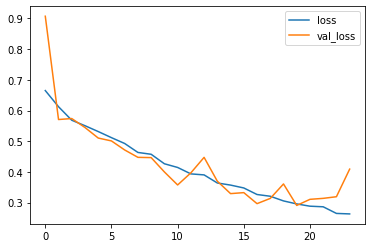

In [81]:
hist[["loss","val_loss"]].plot()

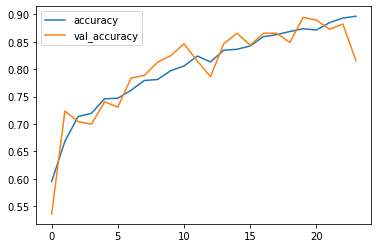

In [82]:
hist[["accuracy","val_accuracy"]].plot()

In [93]:
prediction=model.predict(test)

In [94]:
frame=[]
for x in prediction:
  if x>.5:
    frame.append(1)
  else:
    frame.append(0)

In [96]:
Eval(frame, test.classes)

class_rep:
              precision    recall  f1-score   support

           0       0.95      0.78      0.85       258
           1       0.72      0.94      0.82       162

    accuracy                           0.84       420
   macro avg       0.84      0.86      0.84       420
weighted avg       0.86      0.84      0.84       420

conf_matrix:
[[200  58]
 [ 10 152]]


# Model 3

In [99]:
model=Sequential()

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(3,3))

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(3,3))

model.add(Flatten())

model.add(Dense(32, activation="relu"))
model.add(Dropout(.5))

model.add(Dense(32, activation="relu"))
model.add(Dropout(.5))

model.add(Dense(1, activation="sigmoid"))


model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer="rmsprop")

model.fit_generator(train, validation_data=(val), epochs=1500,  callbacks=[es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/1500
105/105 [==============================] - 17s 152ms/step - loss: 0.7895 - accuracy: 0.5051 - val_loss: 0.8609 - val_accuracy: 0.5000
Epoch 2/1500
105/105 [==============================] - 15s 147ms/step - loss: 0.7215 - accuracy: 0.5120 - val_loss: 0.7173 - val_accuracy: 0.5024
Epoch 3/1500
105/105 [==============================] - 15s 146ms/step - loss: 0.7097 - accuracy: 0.4922 - val_loss: 0.8105 - val_accuracy: 0.5000
Epoch 4/1500
105/105 [==============================] - 15s 146ms/step - loss: 0.7071 - accuracy: 0.5228 - val_loss: 0.6934 - val_accuracy: 0.5312
Epoch 5/1500
105/105 [==============================] - 15s 147ms/step - loss: 0.7018 - accuracy: 0.5348 - val_loss: 0.6677 - val_accuracy: 0.5962
Epoch 6/1500
105/105 [==============================] - 15s 147ms/step - loss: 0.6825 - accuracy: 0.5566 - val_loss: 0.6780 - val_accuracy: 0.5505
Epoch 7/1500
105/105 [==============================] - 15s 147ms/step - loss: 0.6752 - accuracy: 0.5758 - val_loss: 0

In [100]:
hist=pd.DataFrame(model.history.history)

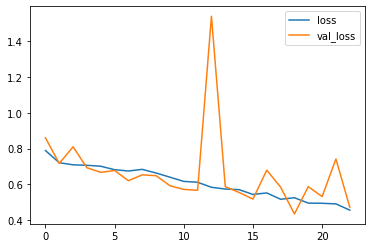

In [101]:
hist[["loss","val_loss"]].plot()

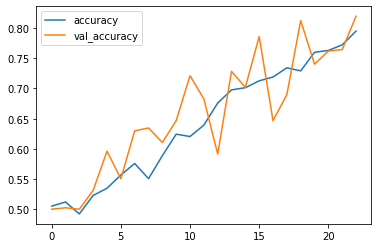

In [102]:
hist[["accuracy","val_accuracy"]].plot()

In [103]:
prediction=model.predict(test)

In [104]:
frame=[]
for x in prediction:
  if x>.5:
    frame.append(1)
  else:
    frame.append(0)

In [105]:
Eval(frame, test.classes)

class_rep:
              precision    recall  f1-score   support

           0       0.71      0.95      0.82       158
           1       0.96      0.77      0.86       262

    accuracy                           0.84       420
   macro avg       0.84      0.86      0.84       420
weighted avg       0.87      0.84      0.84       420

conf_matrix:
[[150   8]
 [ 60 202]]
